Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
!pip install -q git+https://github.com/tensorflow/examples.git

In [ ]:
!pip install -q -U tfds-nightly

In [ ]:
!pip install tensorflow_datasets

In [20]:
import tensorflow as tf

from tensorflow_examples.models.pix2pix import pix2pix
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

**Download the Caltech-UCSD Birds dataset**

Caltech-UCSD Birds 200 (CUB-200) is an image dataset with photos of 200 bird species. There are 200 categories of birds and there are 6033 images in the 2010 dataset. Annotations include segmentation labels.

In [5]:
dataset, info = tfds.load('caltech_birds2010', with_info=True)

In [6]:
print("Number of train samples:", info.splits['train'].num_examples)
print("Number of test samples: ", info.splits['test'].num_examples)

Number of train samples: 3000
Number of test samples:  3033


In [7]:
print(info)

tfds.core.DatasetInfo(
    name='caltech_birds2010',
    full_name='caltech_birds2010/0.1.1',
    description="""
    Caltech-UCSD Birds 200 (CUB-200) is an image dataset with photos 
    of 200 bird species (mostly North American). The total number of 
    categories of birds is 200 and there are 6033 images in the 2010 
    dataset and 11,788 images in the 2011 dataset.
    Annotations include bounding boxes, segmentation labels.
    """,
    homepage='http://www.vision.caltech.edu/visipedia/CUB-200.html',
    data_path='C:\\Users\\Xenia\\tensorflow_datasets\\caltech_birds2010\\0.1.1',
    download_size=659.14 MiB,
    dataset_size=659.64 MiB,
    features=FeaturesDict({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=200),
        'label_name': Text(shape=(), dtype=tf.string),
        's

In [8]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [79]:
@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
    print("Image size: ", input_image.shape, " and Mask size: ", input_mask.shape)

    # Flip an image horizontally (left to right)
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
        
    # Scale image
    input_image = tf.cast(input_image, tf.float32) / 255.0
#     input_mask -= 1

    return input_image, input_mask

In [80]:
def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    # Scale image
    input_image = tf.cast(input_image, tf.float32) / 255.0
#     input_mask -= 1
    print("input_mask = ", input_mask)
    
    return input_image, input_mask

Image size:  (128, 128, 3)  and Mask size:  (128, 128, 1)
input_mask =  Tensor("resize_1/Squeeze:0", shape=(128, 128, 1), dtype=float32)


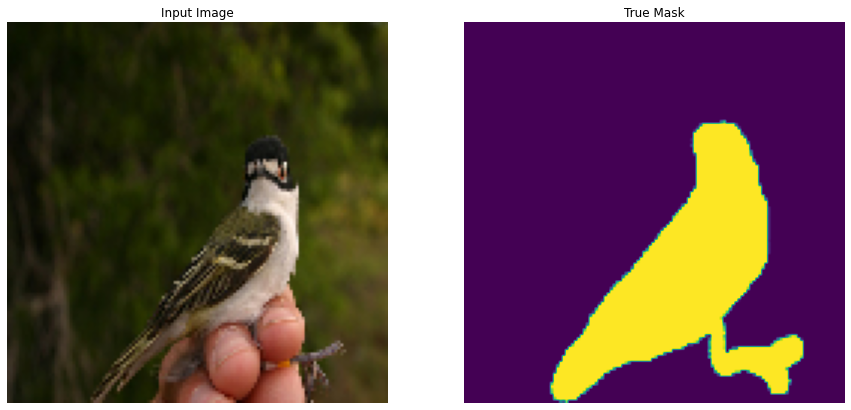

In [81]:
train = dataset['train'].map(load_image_train)
test = dataset['test'].map(load_image_test)

for image, mask in train.take(1):
    
    display([image, mask])

In [95]:
TRAIN_SAMPLES = info.splits['train'].num_examples
TEST_SAMPLES = info.splits['test'].num_examples
OUTPUT_CHANNELS = 3
BATCH_SIZE = 100
BUFFER_SIZE = 5000
STEPS_PER_EPOCH = TRAIN_SAMPLES // BATCH_SIZE

# Cache and shuffle
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

**MobileNetV2** is a Convolutional Neural Network architecture and it has been released by Google on March 2019. This model improves the performance of mobile models and efficiently can be applied in applications about object detection and image segmentation. Hence, our encoder will be a pretrained MobileNetV2, which is also available in ``tf.keras.applications``.

In [56]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [57]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

**UNET** is a Fully Convolutional Network (FCN) which solves the Semantic Segmentation problem. The goal of ``Semantic Image Segmentation`` is to label each pixel of an image with a corresponding class.

The expected output in semantic segmentation are not just labels and bounding box parameters. The output itself is a high resolution image (typically of the same size as input image) in which each pixel is classified to a particular class. Thus it is a **pixel level image classification**.

The UNET architecture contains two paths. First path is the **encoder**, which is used to capture the context in the image. The encoder is just a traditional stack of convolutional and max pooling layers. The second path is the **decoder**, which is used to enable precise localization using ``transposed convolutions``. Thus it is an end-to-end fully convolutional network (FCN), i.e. it only contains Convolutional layers and does not contain any Dense layer because of which it can accept image of any size.

In [87]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    x = inputs

    # Downsampling through the model
    residuals = down_stack(x)
    x = residuals[-1]
    residuals = reversed(residuals[:-1])

    # Upsampling and establishing the residual connections
    for up, residual in zip(up_stack, residuals):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, residual])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [96]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [97]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [98]:
def show_predictions(dataset, num=1):
    for image, mask in dataset.take(num):
        pred_mask = model.predict(image)
        display([image[0], mask[0], create_mask(pred_mask)])

**Test model before training**

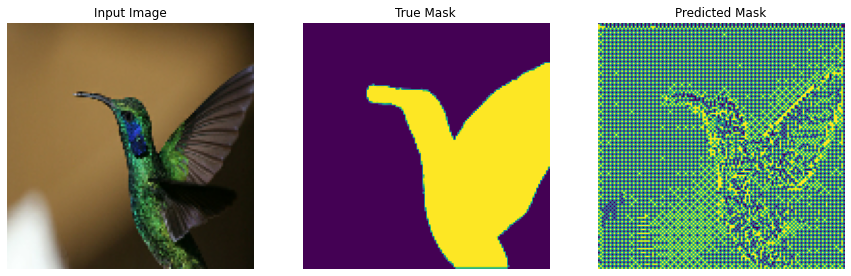

In [19]:
show_predictions(test_dataset, num=1)

**Training the model**

In [105]:
EPOCHS = 40
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

# earlystop_callback = EarlyStopping(monitor = 'val_loss', 
#                                    mode = 'min',
#                                    verbose = 1,
#                                    patience = 3)

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[])
#                           callbacks=[earlystop_callback])

Epoch 1/40
30/30 [==============================] - 273s 9s/step - loss: 0.8235 - accuracy: 0.7237 - val_loss: 0.8265 - val_accuracy: 0.7159
Epoch 2/40
30/30 [==============================] - 281s 9s/step - loss: 0.8105 - accuracy: 0.7241 - val_loss: 0.7977 - val_accuracy: 0.7400
Epoch 3/40
30/30 [==============================] - 276s 9s/step - loss: 0.7906 - accuracy: 0.7340 - val_loss: 0.7939 - val_accuracy: 0.7180
Epoch 4/40
30/30 [==============================] - 275s 9s/step - loss: 0.7869 - accuracy: 0.7345 - val_loss: 0.7882 - val_accuracy: 0.7271
Epoch 5/40
30/30 [==============================] - 275s 9s/step - loss: 0.7887 - accuracy: 0.7319 - val_loss: 0.7911 - val_accuracy: 0.7333
Epoch 6/40
30/30 [==============================] - 274s 9s/step - loss: 0.7864 - accuracy: 0.7335 - val_loss: 0.7846 - val_accuracy: 0.7397
Epoch 7/40
30/30 [==============================] - 275s 9s/step - loss: 0.7835 - accuracy: 0.7345 - val_loss: 0.7814 - val_accuracy: 0.7379
Epoch 8/40
30

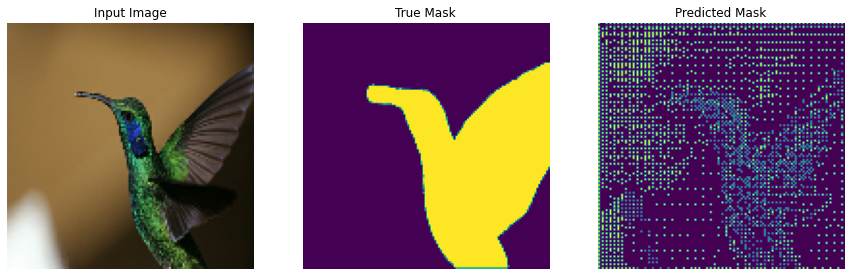

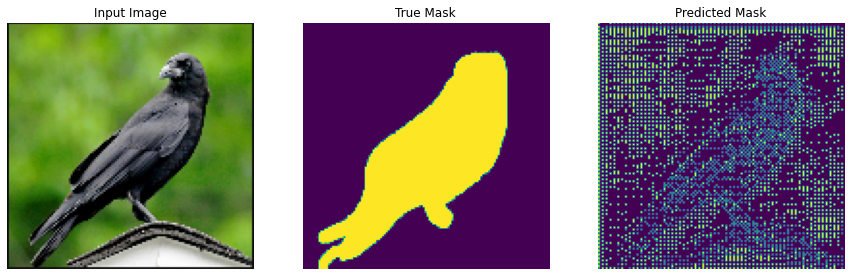

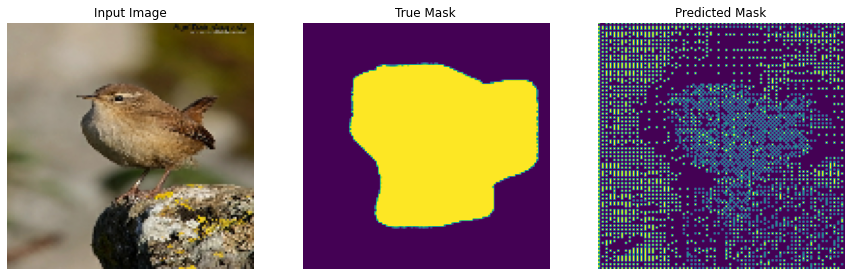

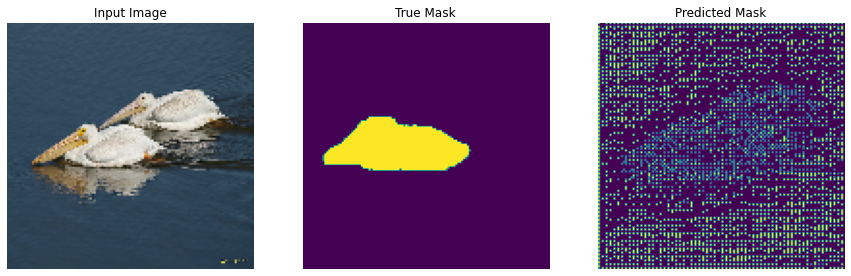

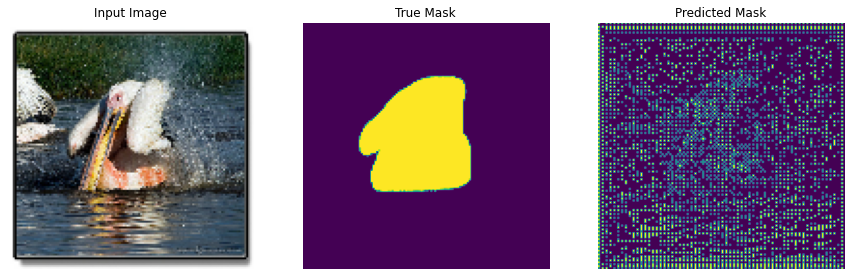

In [107]:
show_predictions(test_dataset, 5)

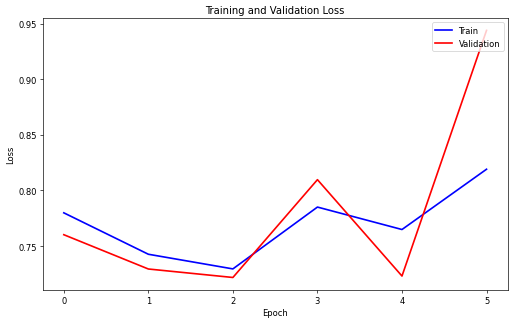

In [35]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=60)
ax.plot(model_history.history['loss'], 'b', label='Train', linewidth=2)
ax.plot(model_history.history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel("Loss")
ax.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()